Inverse Problem for the Lorenz System

In [1]:
# We import the necessary libraries
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# This is a trivial problem, so we already have the solution computed using a solver. We import it.
def gen_traindata():
    data = np.load("../lorenz/Lorenz.npz")
    return data["t"], data["y"]

In [3]:
# Our aim is to find the 3 unknown variables (sigma, rho, beta) for the system of equations.
C1 = dde.Variable(1.0) # sigma
C2 = dde.Variable(1.0) # rho
C3 = dde.Variable(1.0) # beta

In [4]:
# We create the Lorenz system
def Lorenz_system(x, y):
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]
# x represents the t coordinate
# y represents the network output ie the solution y(x(t),y(t),z(t)) or as we've written it here y(y1,y2,y3)

In [5]:
# We need to implement a function that returns true for points inside the subdomain and false for the points outside
def boundary(_, on_initial):
    return on_initial

In [6]:
# We create a time domain class
geom = dde.geometry.TimeDomain(0, 3)

In [7]:
# We specify the initial conditions
ic1 = dde.icbc.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 27, boundary, component=2)

In [8]:
# Organize and assign training data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)


In [9]:
# Define the PDE
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400, # number of points in the domain
    num_boundary=2, # number of points on the boundary
    anchors=observe_t, # extra points used for training
)

In [10]:
# We define and set the parameters for the Neural Network
net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [11]:
# We give indications that C1, C2 and C3 need to be trained alongside the other parameters in the NN. This
# is how we estimate their value. They will then be saved in a file called variables.dat
external_trainable_variables = [C1, C2, C3]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

In [12]:
# Train the NN using ADAM as an optimizer
model.compile(
    "adam", lr=0.001, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.059927 s



/Users/giuliadesanctis/PycharmProjects/compStat/venv/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.352216 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [6.64e-01, 5.46e-01, 4.56e-02, 6.40e+01, 4.90e+01, 7.29e+02, 3.74e+01, 3.69e+01, 2.56e+02]    [6.64e-01, 5.46e-01, 4.56e-02, 6.40e+01, 4.90e+01, 7.29e+02, 3.74e+01, 3.69e+01, 2.56e+02]    []  


2024-03-12 19:32:31.698405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


1000      [6.29e+00, 2.74e+00, 2.61e+00, 3.24e+01, 4.66e-04, 2.07e+00, 3.32e+01, 6.28e+00, 1.08e+01]    [6.29e+00, 2.74e+00, 2.61e+00, 3.24e+01, 4.66e-04, 2.07e+00, 3.32e+01, 6.28e+00, 1.08e+01]    []  
2000      [9.30e+00, 1.98e+00, 1.35e+00, 1.83e+01, 2.96e-01, 1.69e+00, 3.29e+01, 1.38e+01, 5.18e+00]    [9.30e+00, 1.98e+00, 1.35e+00, 1.83e+01, 2.96e-01, 1.69e+00, 3.29e+01, 1.38e+01, 5.18e+00]    []  
3000      [8.73e+00, 2.08e+00, 1.17e+00, 1.49e+01, 3.63e-01, 1.52e+00, 3.29e+01, 1.70e+01, 3.20e+00]    [8.73e+00, 2.08e+00, 1.17e+00, 1.49e+01, 3.63e-01, 1.52e+00, 3.29e+01, 1.70e+01, 3.20e+00]    []  
4000      [8.46e+00, 2.06e+00, 7.92e-01, 1.21e+01, 3.86e-01, 1.35e+00, 3.27e+01, 1.88e+01, 2.47e+00]    [8.46e+00, 2.06e+00, 7.92e-01, 1.21e+01, 3.86e-01, 1.35e+00, 3.27e+01, 1.88e+01, 2.47e+00]    []  
5000      [8.11e+00, 2.26e+00, 6.37e-01, 1.02e+01, 3.68e-01, 1.24e+00, 3.24e+01, 1.96e+01, 2.05e+00]    [8.11e+00, 2.26e+00, 6.37e-01, 1.02e+01, 3.68e-01, 1.24e+00, 3.24e+01, 1.96e+01, 2.0

Compiling model...
'compile' took 0.130462 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
60000     [1.80e-02, 1.36e-02, 5.94e-02, 3.97e-06, 9.98e-05, 2.46e-05, 3.63e-04, 5.84e-04, 4.37e-04]    [1.80e-02, 1.36e-02, 5.94e-02, 3.97e-06, 9.98e-05, 2.46e-05, 3.63e-04, 5.84e-04, 4.37e-04]    []  
61000     [6.04e-04, 3.81e-04, 9.19e-04, 2.18e-06, 2.30e-07, 7.93e-07, 9.95e-06, 1.08e-05, 1.81e-05]    [6.04e-04, 3.81e-04, 9.19e-04, 2.18e-06, 2.30e-07, 7.93e-07, 9.95e-06, 1.08e-05, 1.81e-05]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000932
  Number of iterations: 1548
  Number of functions evaluations: 1617
61606     [2.13e-04, 2.02e-04, 4.95e-04, 7.87e-09, 4.03e-07, 9.46e-09, 8.33e-06, 6.01e-06, 7.11e-06]    [2.1

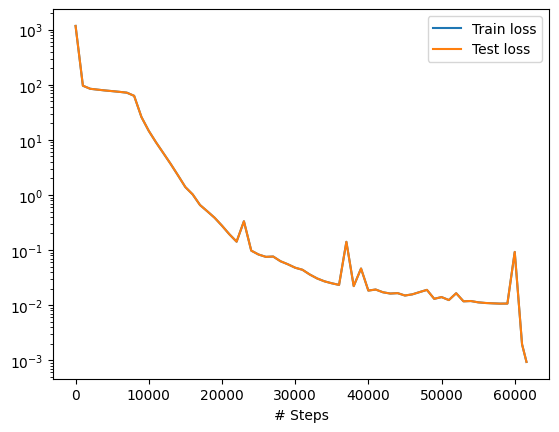

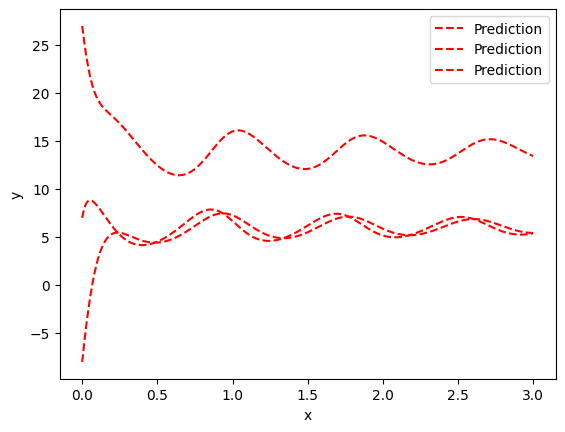

In [13]:
# Train the NN using lbfgs to further reduce loss
model.compile("L-BFGS", external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

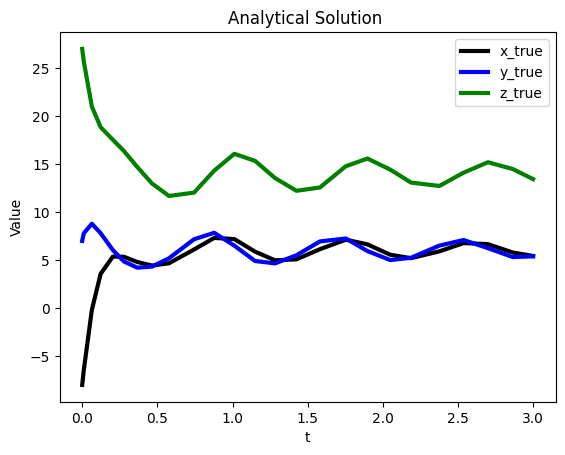

In [14]:
# We plot a graph with the real solution to the problem
plt.xlabel("t")
plt.ylabel("Value")

check = np.load("../lorenz/Lorenz.npz")
t = check['t']
x = check['y'][:,0]
y = check['y'][:,1]
z = check['y'][:,2]

plt.plot(t, x, color="black", label="x_true", linewidth = 3)
plt.plot(t, y, color="blue", label="y_true", linewidth = 3)
plt.plot(t, z, color="green", label="z_true", linewidth = 3)
plt.title ("Analytical Solution ")
plt.legend(['x_true', 'y_true', 'z_true'])

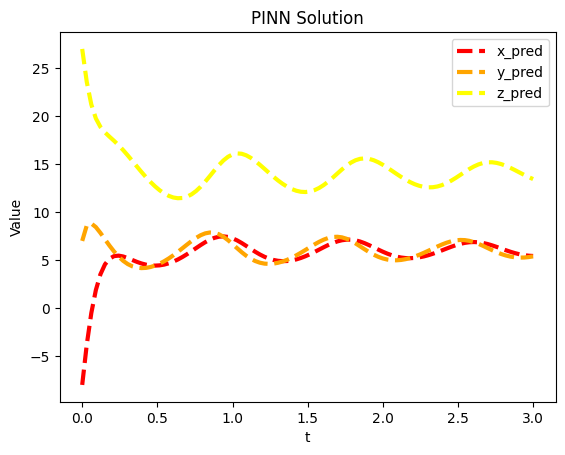

In [15]:
# We now plot a graph with the solution found by the NN
t = np.linspace(0,3,100).reshape(100,1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]
z_pred = sol_pred[:, 2:]

plt.plot(t, x_pred, color="red", linestyle="dashed", label="x_pred", linewidth = 3)
plt.plot(t, y_pred, color="orange", linestyle="dashed", label="y_pred", linewidth = 3)
plt.plot(t, z_pred, color="yellow", linestyle="dashed", label="z_pred", linewidth = 3)

plt.title("PINN Solution")

plt.xlabel("t")
plt.ylabel("Value")
plt.legend()
plt.show()

In [16]:
# DeepXDE automatically saves the variables in a .dat file, they need to be extracted in order to make plots
var = np.genfromtxt("variables.dat",
                     dtype=list,
                     delimiter=' ',
                    usecols=(1))
var

array([b'[1.00e+00,', b'[4.11e-01,', b'[2.62e-01,', b'[3.29e-01,',
       b'[3.64e-01,', b'[3.90e-01,', b'[4.38e-01,', b'[4.73e-01,',
       b'[5.05e-01,', b'[5.37e-01,', b'[5.66e-01,', b'[5.97e-01,',
       b'[6.32e-01,', b'[6.84e-01,', b'[1.85e+00,', b'[2.88e+00,',
       b'[3.67e+00,', b'[4.34e+00,', b'[4.92e+00,', b'[5.44e+00,',
       b'[5.90e+00,', b'[6.34e+00,', b'[6.76e+00,', b'[7.17e+00,',
       b'[7.56e+00,', b'[7.93e+00,', b'[8.29e+00,', b'[8.61e+00,',
       b'[8.89e+00,', b'[9.12e+00,', b'[9.29e+00,', b'[9.42e+00,',
       b'[9.50e+00,', b'[9.57e+00,', b'[9.64e+00,', b'[9.69e+00,',
       b'[9.73e+00,', b'[9.77e+00,', b'[9.80e+00,', b'[9.82e+00,',
       b'[9.84e+00,', b'[9.85e+00,', b'[9.86e+00,', b'[9.87e+00,',
       b'[9.88e+00,', b'[9.88e+00,', b'[9.89e+00,', b'[9.90e+00,',
       b'[9.90e+00,', b'[9.91e+00,', b'[9.91e+00,', b'[9.92e+00,',
       b'[9.92e+00,', b'[9.93e+00,', b'[9.94e+00,', b'[9.94e+00,',
       b'[9.95e+00,', b'[9.95e+00,', b'[9.96e+00,', b'[9.96e+0

In [59]:
check = np.load("../lorenz/Lorenz.npz")
check['y'][:, 0]

array([-8.        , -6.43173669, -0.18252838,  3.57229135,  5.36627   ,
        5.35148452,  4.80410766,  4.43677847,  4.67479693,  6.10611558,
        7.31176996,  7.19516841,  5.8841517 ,  4.98045591,  5.07979114,
        6.13917344,  7.12620686,  6.64255444,  5.56305455,  5.20087412,
        5.91620229,  6.7730354 ,  6.66760163,  5.79518366,  5.43023844])

In [60]:
x = check['y'][:,0]
y = check['y'][:,1]
z = check['y'][:,2]
t = check['t']

In [61]:
x.shape, y.shape, z.shape, t.shape

((25,), (25,), (25,), (25, 1))

In [17]:
filename = '/Users/giuliadesanctis/PycharmProjects/compStat/lorenz/variables.dat'
with open(filename) as file:
    lines = [line.rstrip() for line in file]
lines

['0 [1.00e+00, 1.00e+00, 1.00e+00]',
 '600 [4.11e-01, 1.28e+00, 4.58e-01]',
 '1200 [2.62e-01, 1.67e+00, 2.69e-01]',
 '1800 [3.29e-01, 2.26e+00, 1.90e-01]',
 '2400 [3.64e-01, 2.94e+00, 1.63e-01]',
 '3000 [3.90e-01, 3.63e+00, 1.48e-01]',
 '3600 [4.38e-01, 4.34e+00, 1.36e-01]',
 '4200 [4.73e-01, 5.03e+00, 1.39e-01]',
 '4800 [5.05e-01, 5.69e+00, 1.34e-01]',
 '5400 [5.37e-01, 6.37e+00, 1.23e-01]',
 '6000 [5.66e-01, 7.04e+00, 1.23e-01]',
 '6600 [5.97e-01, 7.71e+00, 1.26e-01]',
 '7200 [6.32e-01, 8.38e+00, 1.37e-01]',
 '7800 [6.84e-01, 9.10e+00, 1.87e-01]',
 '8400 [1.85e+00, 1.02e+01, 1.41e+00]',
 '9000 [2.88e+00, 1.10e+01, 2.01e+00]',
 '9600 [3.67e+00, 1.16e+01, 2.39e+00]',
 '10200 [4.34e+00, 1.21e+01, 2.62e+00]',
 '10800 [4.92e+00, 1.25e+01, 2.75e+00]',
 '11400 [5.44e+00, 1.29e+01, 2.81e+00]',
 '12000 [5.90e+00, 1.33e+01, 2.80e+00]',
 '12600 [6.34e+00, 1.37e+01, 2.78e+00]',
 '13200 [6.76e+00, 1.40e+01, 2.76e+00]',
 '13800 [7.17e+00, 1.43e+01, 2.73e+00]',
 '14400 [7.56e+00, 1.45e+01, 2.71e+00

In [18]:
C1 = []
C2 = []
C3 = []
for line in lines:
    line = line.split(" ")
    C1.append(float(line[1].replace(",", "").replace("[","")))
    C2.append(float(line[2].replace(",","")))
    C3.append(float(line[3].replace("]","")))

[1.0,
 0.458,
 0.269,
 0.19,
 0.163,
 0.148,
 0.136,
 0.139,
 0.134,
 0.123,
 0.123,
 0.126,
 0.137,
 0.187,
 1.41,
 2.01,
 2.39,
 2.62,
 2.75,
 2.81,
 2.8,
 2.78,
 2.76,
 2.73,
 2.71,
 2.7,
 2.69,
 2.69,
 2.69,
 2.69,
 2.69,
 2.69,
 2.68,
 2.68,
 2.68,
 2.68,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67,
 2.67]

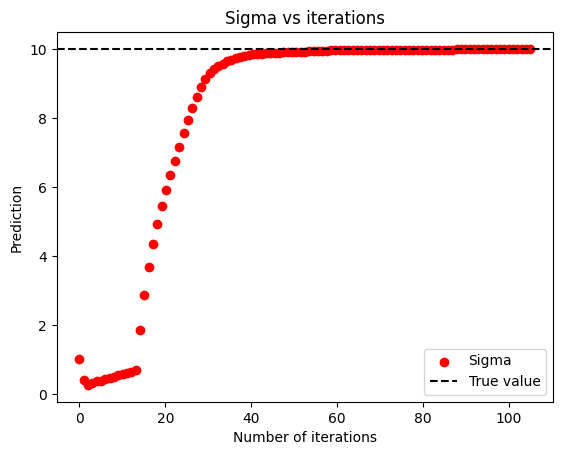

In [22]:
# Graph for C1
plt.xlabel("Number of iterations")
plt.ylabel("Prediction")
plt.title ("Sigma vs iterations")

n = len(C1)
t = np.linspace(0,n,n)
plt.scatter (t, C1, color = "red", label = "Sigma")
plt.axhline(y=10, color='black', linestyle='dashed', label = "True value")
plt.legend()

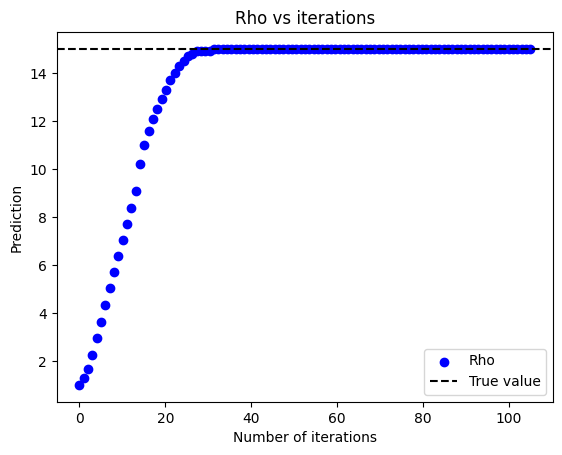

In [26]:
# Graph for C2
plt.xlabel("Number of iterations")
plt.ylabel("Prediction")
plt.title ("Rho vs iterations")

n = len(C2)
t = np.linspace(0,n,n)
plt.scatter (t, C2, color = "blue", label = "Rho")
plt.axhline(y=15, color='black', linestyle='dashed', label = "True value")
plt.legend()

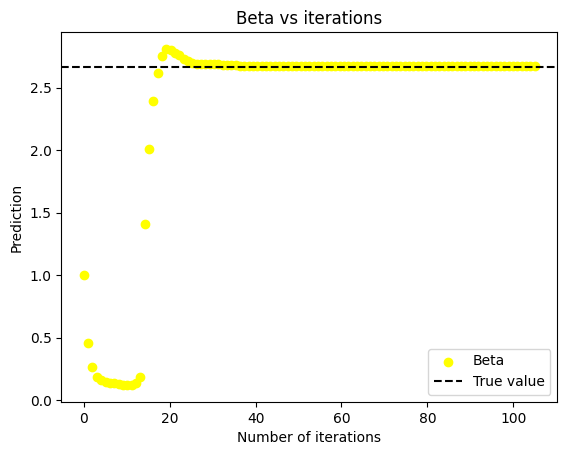

In [29]:
# Graph for C3
plt.xlabel("Number of iterations")
plt.ylabel("Prediction")
plt.title ("Beta vs iterations")

n = len(C3)
t = np.linspace(0,n,n)
plt.scatter (t, C3, color = "yellow", label = "Beta")
plt.axhline(y=8/3, color='black', linestyle='dashed', label = "True value")
plt.legend()